# 3D Conformation Prediction

In [1080]:
import pandas as pd
import numpy as np
import os
import glob
import torch
import torch.nn.functional as F
from tqdm import tqdm
from rdkit.Chem import MolFromSmiles

In [1081]:
from IPython import get_ipython

def tqdm_clear(*args, **kwargs):
    from tqdm import tqdm
    getattr(tqdm, '_instances', {}).clear()

get_ipython().events.register('post_execute', tqdm_clear)

## Load QM9

In [1099]:
file_re = os.path.join('./qm92', '*.xyz')
file_pathes = glob.glob(file_re)
file_pathes.sort()
ls = []
_smiles_column_names = ['smiles1', 'smiles2']
_label_names = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
                'zpve', 'U0', 'U', 'H', 'G', 'Cv']

y = []
for ix,path in enumerate(tqdm(file_pathes)):
    with open(path, 'r') as f:
        data = [line.strip() for line in f]
        
    num_atom = int(data[0])
    # We're only interested in molecules with 3 or more molecules
    if num_atom < 3:
        continue
    properties = list(map(float, data[1].split('\t')[1:]))
    ys = []
    for ix_pos in range(2,num_atom+2):
        if not data[ix_pos][0] == 'H':
            ys.append(list(map(float, data[ix_pos].replace('*^', 'e').split('\t')[1:]))[:3])

    if len(ys) < 3:
        continue
    y.append(ys)

    smiles = data[3 + num_atom].split('\t')
    new_ls = smiles + properties
    ls.append(new_ls)

df = pd.DataFrame(ls, columns= _smiles_column_names + _label_names)

100%|██████████| 133885/133885 [00:05<00:00, 23208.47it/s]


In [1100]:
df.sample(5)

,smiles1,smiles2,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
82163,CC1C2CC2(O)C2CN12,C[C@H]1[C@@H]2C[C@]2(O)[C@H]2CN12,2.63160,1.62494,1.31235,1.2272,77.85,-0.2280,0.0735,0.3015,1052.7234,0.171522,-403.113060,-403.104932,-403.103988,-403.145095,32.888
128416,CNCC1=NOC(C)=N1,CNCc1noc(C)n1,4.90898,0.89182,0.82165,1.9299,74.12,-0.2248,-0.0170,0.2077,1444.0898,0.147633,-435.269120,-435.259876,-435.258931,-435.304285,32.150
39202,C1C2CC1C1NC1CO2,C1[C@H]2C[C@@H]1[C@H]1N[C@H]1CO2,2.48063,2.00204,1.50992,2.4522,77.72,-0.2355,0.0654,0.3009,952.9848,0.174639,-403.102586,-403.095653,-403.094709,-403.133486,29.243
32781,CCCC1=C(N)OC=N1,CCCc1c(N)ocn1,3.22283,0.97504,0.78583,2.5417,79.09,-0.1976,0.0220,0.2195,1476.0310,0.159694,-419.246526,-419.237155,-419.236211,-419.281674,33.688
46148,O=C1COC(CO1)C#C,O=C1CO[C@@H](CO1)C#C,4.86241,1.03714,0.88200,3.5025,68.39,-0.2601,-0.0001,0.2600,1233.6663,0.111699,-457.748224,-457.740130,-457.739186,-457.781247,29.673


# Setting up dataset

The first thing we want to do is to find a way of representing a molecule to our graph convolutional network. For this, we will make use of DeepChem which provides a number of 'featurizers'. In this case the features of an atom is a number of descriptors generated from RDKit.

In [1101]:
mols = [MolFromSmiles(row.smiles1) for (ix,row) in df.iterrows()]

In [1161]:
from rdkit.Chem import AllChem
fingerprints = []
for m in mols:
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m, useChirality=True, radius=2, nBits=1024)
    vec1 = np.array(fp1);
    fingerprints.append(vec1)

In [1085]:
import networkx as nx

def create_edge_index(A):
    rows = []
    cols = []
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i,j] == 1:
                rows.append(i)
                cols.append(j)
    return rows, cols

def get_molecule_features(m):
    featurizer = ConvMolFeaturizer()
    return featurizer.featurize([m])[0].get_atom_features()

In [355]:
from deepchem.feat import RDKitDescriptors, ConvMolFeaturizer
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

m = mols[50]
molecule_featurized = get_molecule_features(m)
A = GetAdjacencyMatrix(m)

Let's see how our adjacency matrix looks. This matrix will be used in our graph convolutions.

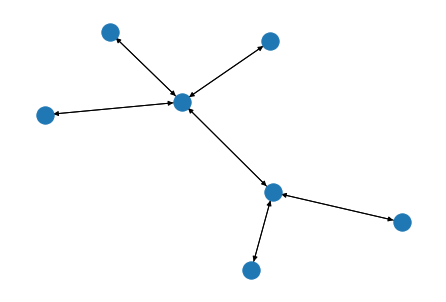

In [13]:
D = nx.to_networkx_graph(A,create_using=nx.DiGraph())
nx.draw(D)

Let's see how the molecule looks in 2D according to RDKit

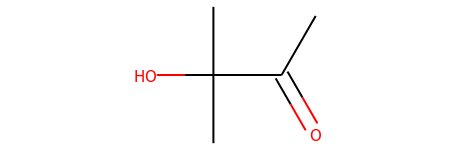

In [14]:
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import IPythonConsole
m

Let's repeat this for all molecules

In [1635]:
from torch_geometric.data import Data, DataLoader
from torchvision import transforms
data_list = []
featurizer = RDKitDescriptors()

for ix, m in enumerate(mols):
    mol_featurized = get_molecule_features(m)
    A = GetAdjacencyMatrix(m)
    edge_index = create_edge_index(A)
    x = torch.tensor(mol_featurized)
    #x_min = torch.min(x)
    #range_x = torch.max(x) - torch.min(x)
    #x = (x - x_min) / range_x
    if not x.shape[0] == torch.DoubleTensor(y[ix]).shape[0]:
        print("Unmatching x and y!")
        print(x.shape)
        print(torch.DoubleTensor(y[ix]).shape)
        break
    d = Data(x=x, edge_index=torch.LongTensor(edge_index), y=torch.DoubleTensor(y[ix]))
    d.fingerprint = fingerprints[ix]
    data_list.append(d)

In [1636]:
loader = DataLoader(data_list, batch_size=32)

# Setting Up Graph Convolutional Network

In [1652]:
from torch_geometric.nn import GCNConv, BatchNorm, GMMConv, SAGEConv, GraphConv, GATConv
from torch_geometric.nn.pool import TopKPooling, EdgePooling, SAGPooling
from torch import nn

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GraphConv(75, 256)
        self.conv2 = GraphConv(256, 256)
        self.batch_norm1 = BatchNorm(256)
        self.linear = nn.Linear(256, 3)
        self.linear2 = nn.Linear(1024, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        x = self.linear(x)
        #x = x.mean(dim=0)
        #fp = torch.DoubleTensor(data.fingerprint).to(device)
        #fp_t = self.linear2(fp)
        #print(fp_t)
        
        #z = torch.cat((x,fp), dim=0)
        #x = self.linear2(z)
        return x

In [1653]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = loader.dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [1654]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [1655]:
import random
random.shuffle(loader.dataset)
N = len(loader.dataset)
num_train = int(N*0.01)
X_train = loader.dataset[:num_train]
X_val = loader.dataset[num_train:]
batch_size = 128
X_train_batched = chunks(X_train, len(X_train) // batch_size)

In [ ]:
model.double()
model.train()
n_epochs = 1000

for epoch in range(n_epochs):
    print("===== Epoch %d of %d ====" % (epoch + 1, n_epochs))
    losses = []
    batch_ix = 0
    num_batches = len(X_train) // batch_size
    random.shuffle(X_train)
    X_train_batched = chunks(X_train, num_batches)
    for batch_ix in tqdm(range(num_batches)):
        batch = next(X_train_batched)
        y_hats = []
        ys = []

        for data in batch:
            data.to(device)
            y_hat = model(data)
            y_hats.append(y_hat)
            ys.append(data.y)
            
        

        y_hats = torch.cat(y_hats)
        ys = torch.cat(ys)
        

        loss = F.mse_loss(y_hats, ys)
        loss.backward()
        losses.append(loss)
        optimizer.step()
        optimizer.zero_grad()
    
    print("Average loss: %.4f" % torch.stack(losses).mean())